In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from data_manager import *
from annotation_utilities import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for AWS compute node


No vtk


In [2]:
margin_um = 200
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB

In [3]:
from scipy.ndimage.morphology import distance_transform_edt

In [4]:
# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {}
    
    for sec in metadata_cache['valid_sections'][stack]:
                
        m = DataManager.load_thumbnail_mask_v3(stack, prep_id=2, section=sec)
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
        
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[sec] = contour_prob_map

In [5]:
from conversion import *

In [6]:
outline_prob_volume, outline_prob_volume_bbox = images_to_volume(images=contour_prob_maps_by_sec, 
                                                                 voxel_size=(XY_PIXEL_DISTANCE_TB, XY_PIXEL_DISTANCE_TB, SECTION_THICKNESS/XY_PIXEL_DISTANCE_TB))

In [7]:
print outline_prob_volume_bbox

(0, 484, 0, 372, 125, 505)


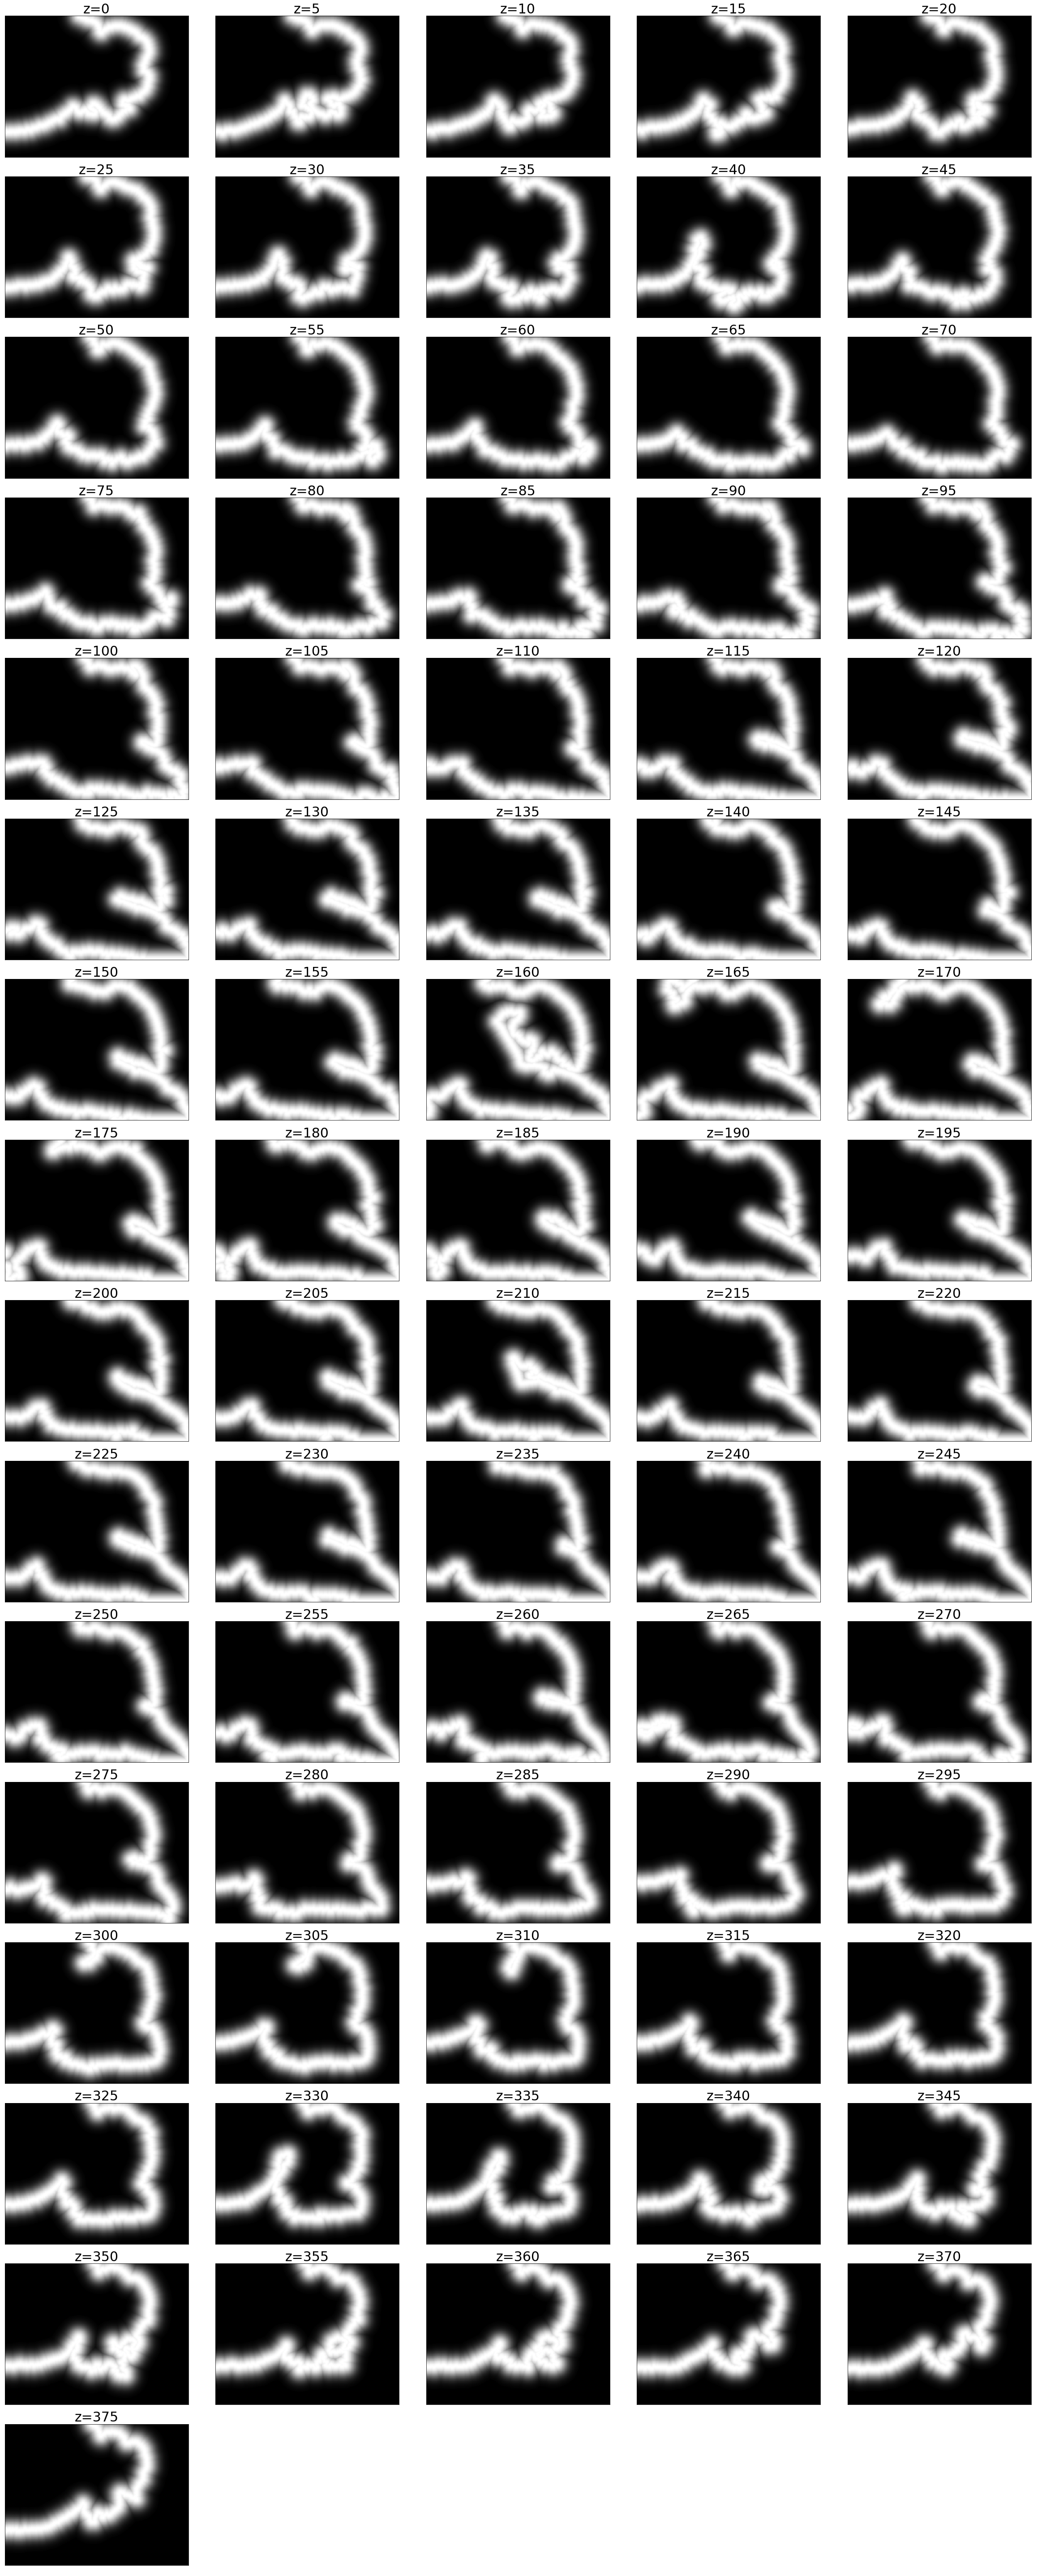

In [8]:
display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

In [ ]:
structure = 'shell'

In [ ]:
score_volume_filepath = DataManager.get_score_volume_filepath(stack=stack, downscale=downscale, structure=structure, detector_id=detector_id, prep_id=2)
create_parent_dir_if_not_exists(score_volume_filepath)
bp.pack_ndarray_file(score_volume.astype(np.float16), score_volume_filepath)
upload_to_s3(score_volume_filepath)

score_volume_bbox_filepath = DataManager.get_score_volume_bbox_filepath(stack=stack, downscale=downscale, structure=structure,
                                                                       detector_id=detector_id, prep_id=2)
np.savetxt(score_volume_bbox_filepath, np.array(score_volume_bbox)[None], fmt='%d')
upload_to_s3(score_volume_bbox_filepath)

In [86]:
# outline_volume, outline_volume_bbox = interpolate_contours_to_volume(contours_grouped_by_pos=contours_valid_by_z, 
#                                                                      interpolation_direction='z', fill=False)

In [87]:
# print outline_volume_bbox

In [89]:
# display_volume_sections(outline_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)